INSTALLATION AND IMPORTING

In [ ]:
!pip install dabl


In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from google.colab import drive

#Load Dataset
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/2019.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FEEDING DATA SET TO THE VARIABLE "df"

In [ ]:
df = pd.read_csv(data_path)

print(df.head())


       P_NAME  P_STATUS      P_MASS  P_MASS_ERROR_MIN  P_MASS_ERROR_MAX  \
0    11 Com b       3.0  6165.86330        -476.74200         476.74200   
1    11 UMi b       3.0  4684.78480        -794.57001         794.57001   
2    14 And b       3.0  1525.57440               NaN               NaN   
3    14 Her b       3.0  1481.07850         -47.67420          47.67420   
4  16 Cyg B b       3.0   565.73385         -25.42624          25.42624   

   P_RADIUS  P_RADIUS_ERROR_MIN  P_RADIUS_ERROR_MAX  P_YEAR   P_UPDATED  ...  \
0       NaN                 NaN                 NaN    2007  2014-05-14  ...   
1       NaN                 NaN                 NaN    2009  2018-09-06  ...   
2       NaN                 NaN                 NaN    2008  2014-05-14  ...   
3       NaN                 NaN                 NaN    2002  2018-09-06  ...   
4       NaN                 NaN                 NaN    1996  2018-09-06  ...   

   P_HABZONE_CON  P_TYPE_TEMP  P_HABITABLE     P_ESI  S_CONSTELLATIO

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4048 entries, 0 to 4047
Columns: 112 entries, P_NAME to P_SEMI_MAJOR_AXIS_EST
dtypes: float64(94), int64(4), object(14)
memory usage: 3.5+ MB


The target variable is "P_HABITABLE" which is having values 0 (inhabitable) or 1 (conservatively habitable) or 2 (optimistically habitable)

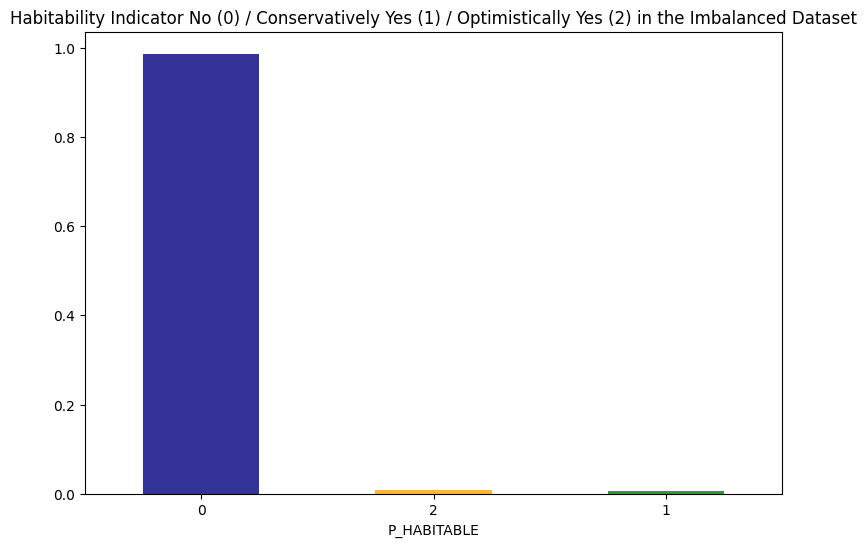

In [ ]:
fig = plt.figure(figsize = (9,6))

# Plot the data
df.P_HABITABLE.value_counts(normalize = True, ascending = False).plot(kind='bar', color= ['navy','orange','green'], alpha = 0.8, rot=0)
plt.title('Habitability Indicator No (0) / Conservatively Yes (1) / Optimistically Yes (2) in the Imbalanced Dataset')
plt.show()

In [ ]:
df.shape

(4048, 112)

In [ ]:
df['P_HABITABLE'].value_counts(normalize=True)

P_HABITABLE
0    0.986413
2    0.008399
1    0.005188
Name: proportion, dtype: float64

* **Initial Exploration with DABL Library**


In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function() {
    return False;
}

<IPython.core.display.Javascript object>

Target looks like classification
Showing only top 10 of 84 continuous features
Linear Discriminant Analysis training set score: 0.865


[<Axes: title={'center': 'Target distribution'}, xlabel='count', ylabel='P_HABITABLE'>,
 [<Figure size 2000x600 with 10 Axes>,
  array([[<Axes: title={'center': '0.778'}, xlabel='P_ESI', ylabel='P_TEMP_EQUIL'>,
          <Axes: title={'center': '0.751'}, xlabel='P_ESI', ylabel='P_TEMP_EQUIL_MIN'>,
          <Axes: title={'center': '0.741'}, xlabel='P_ESI', ylabel='P_TEMP_EQUIL_MAX'>,
          <Axes: title={'center': '0.739'}, xlabel='P_ESI', ylabel='S_TEMPERATURE'>]],
        dtype=object),
  <Figure size 1600x400 with 4 Axes>,
  <Figure size 400x400 with 1 Axes>],
 array([[<Axes: title={'center': 'P_TYPE_TEMP'}>,
         <Axes: title={'center': 'P_TYPE'}>,
         <Axes: title={'center': 'S_TYPE_TEMP'}>,
         <Axes: title={'center': 'P_DETECTION'}>]], dtype=object)]

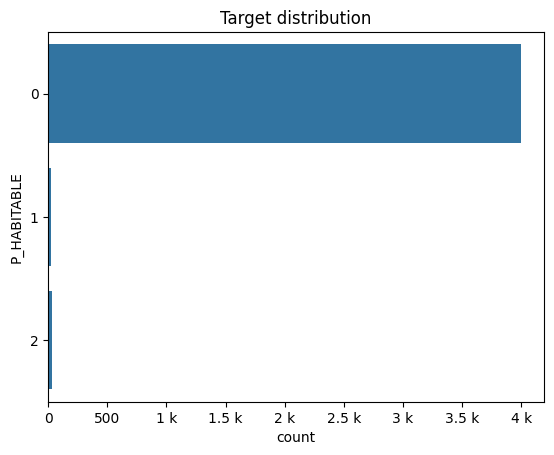

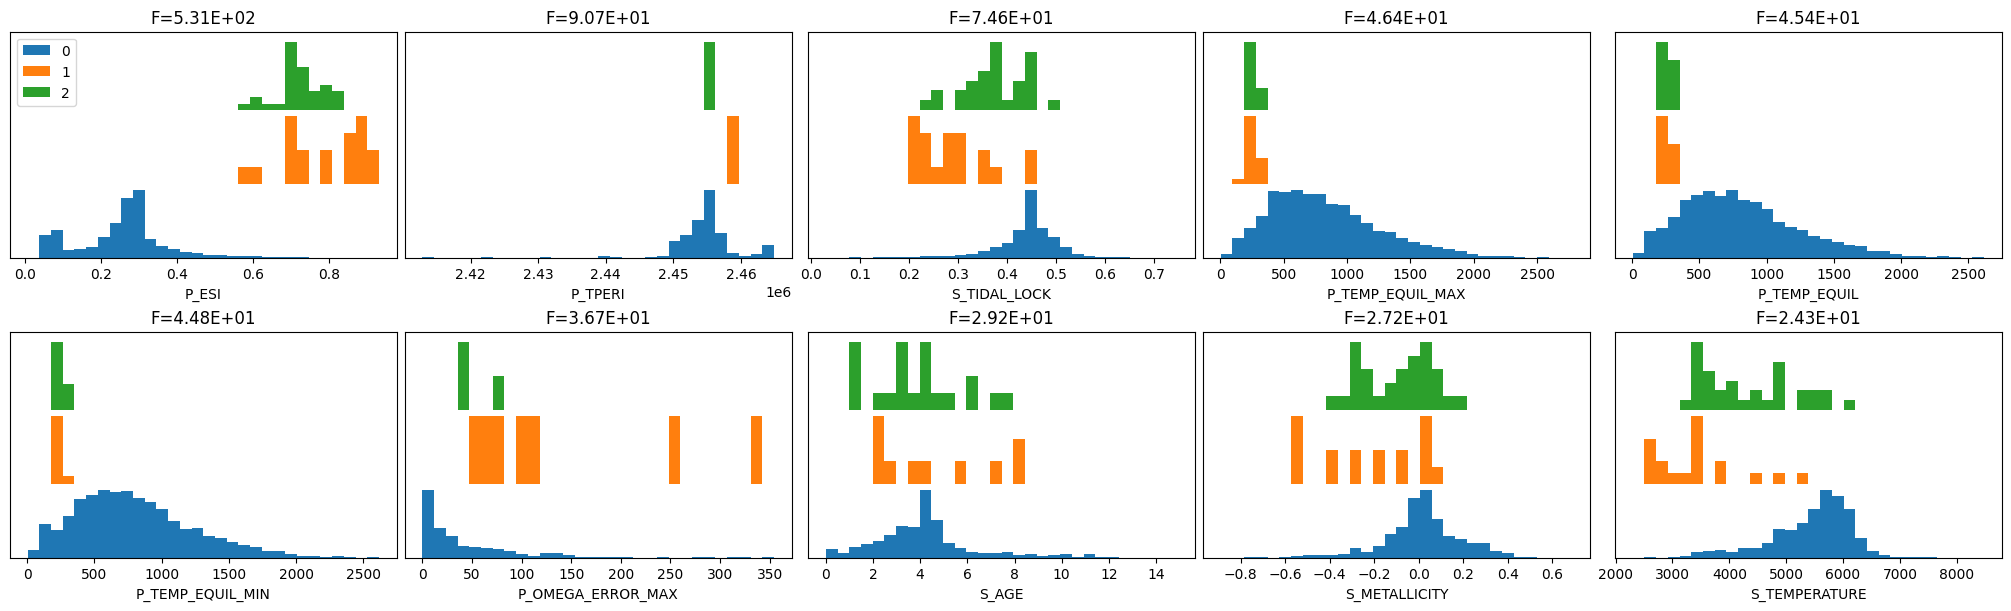

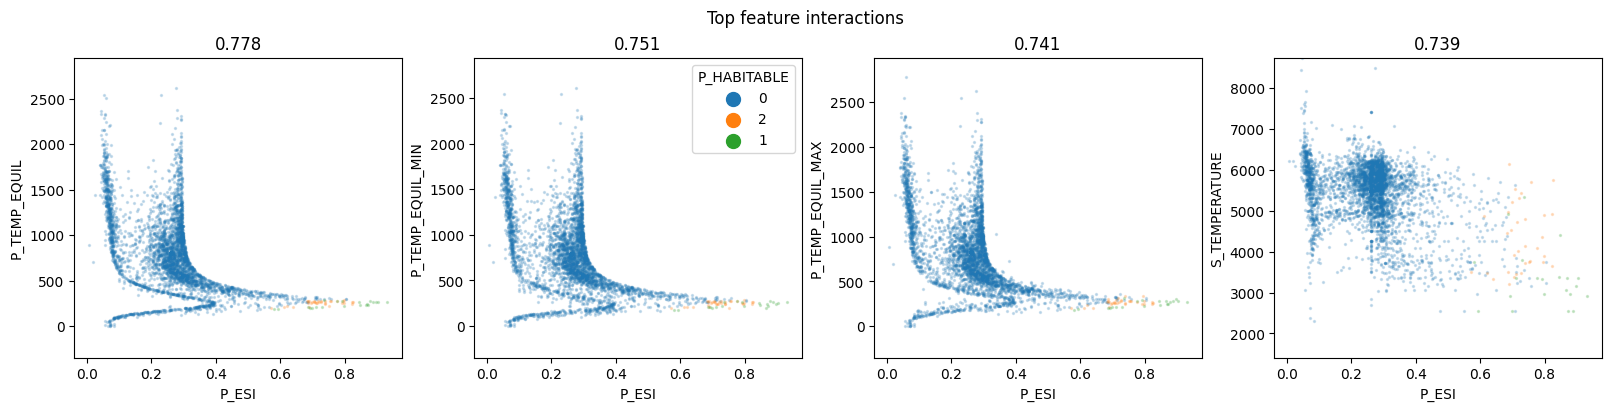

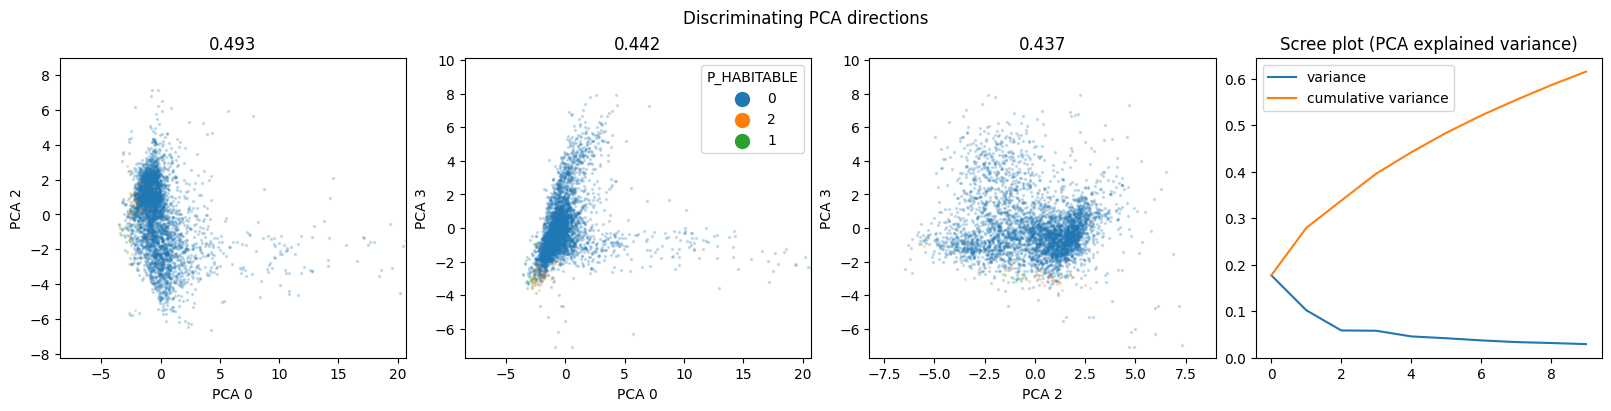

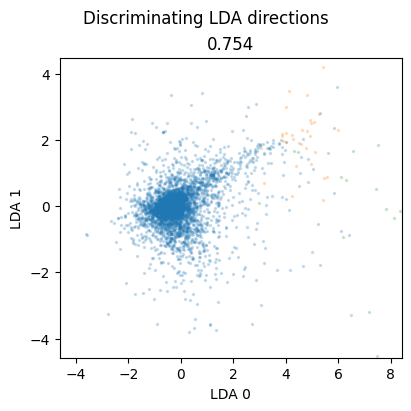

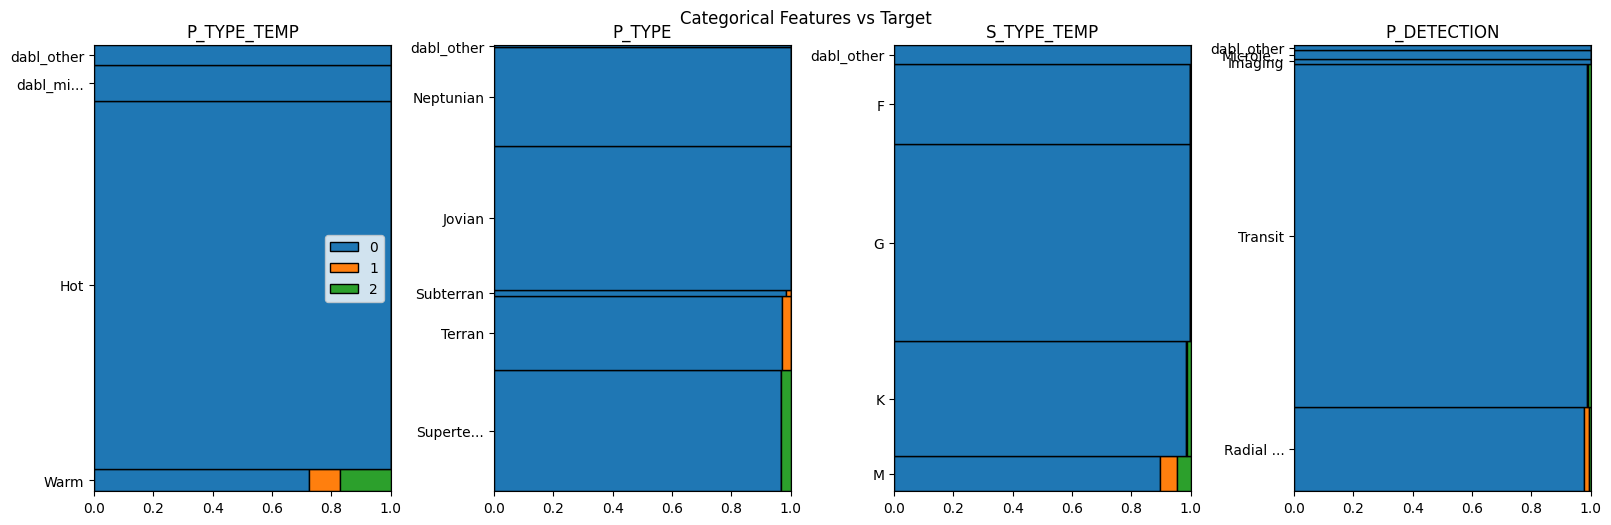

In [ ]:
import dabl
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
dabl.plot(df, target_col = 'P_HABITABLE')

Clearly the data set is imbalanced having 98.64% inhabitable planets. Only 0.84% and 0.52% are conservatively habitable and optimistically habitable planets respectively. For balancing the data set first where each class will be having the same proportion of representation. We are using simple oversampling technique (resampling strategy) for that.

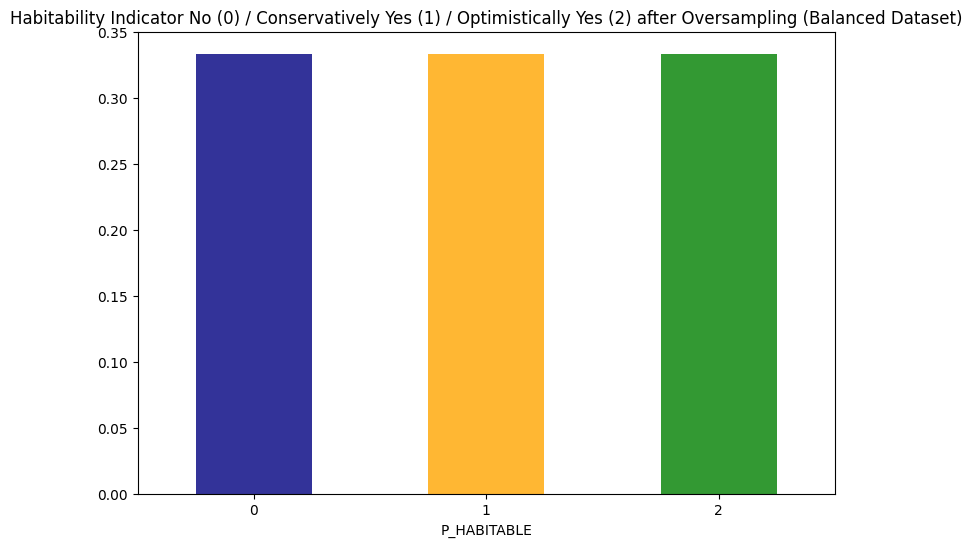

In [ ]:
from sklearn.utils import resample

no = df[df.P_HABITABLE == 0]
yes_cons = df[df.P_HABITABLE == 1]
yes_opti = df[df.P_HABITABLE == 2]
yes_cons_oversampled = resample(yes_cons, replace=True, n_samples=len(no), random_state=12345)
oversampled = pd.concat([no, yes_cons_oversampled])
yes_opti_oversampled = resample(yes_opti, replace=True, n_samples=len(no), random_state=12345)
oversampled = pd.concat([oversampled, yes_opti_oversampled])

fig = plt.figure(figsize = (9,6))
oversampled.P_HABITABLE.value_counts(normalize = True, ascending = False).plot(kind='bar', color= ['navy','orange','green'], alpha = 0.8, rot=0)
plt.title('Habitability Indicator No (0) / Conservatively Yes (1) / Optimistically Yes (2) after Oversampling (Balanced Dataset)')
plt.show()

In [ ]:
oversampled['P_HABITABLE'].value_counts(normalize=True)

0    0.333333
1    0.333333
2    0.333333
Name: P_HABITABLE, dtype: float64

Now we can observe that each class is having equal proportion of representation in the oversampled data set.

## Visualizing the missing data

<Axes: >

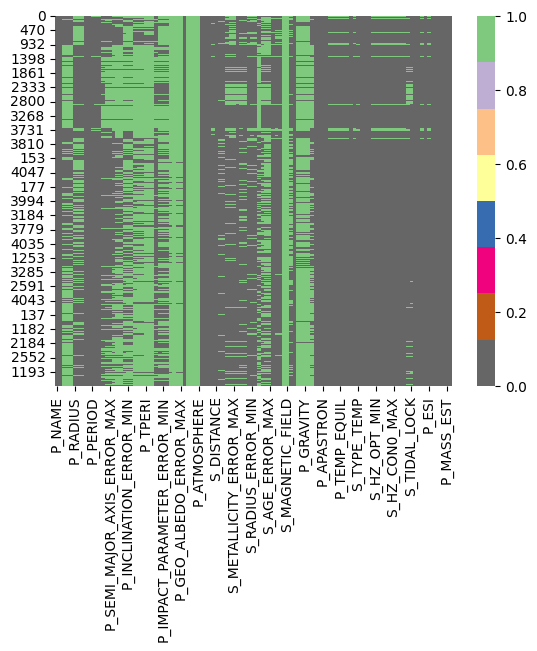

In [ ]:
import seaborn as sns
sns.heatmap(oversampled.isnull(), cmap='Accent_r')

In [ ]:
#Calculate the total number of examples
count = df.isnull().sum().sort_values(ascending=False)

#Return the fraction of a column which is filled with missing values
percent = ((df.isnull().sum()/df.isnull().count())*100).\
sort_values(ascending=False)

#Merge count and percent to display
missing = pd.concat([count, percent], axis = 1, keys = ['Count', '%'])

missing.head(60)

,Count,%
P_DETECTION_MASS,4048,100.000000
P_GEO_ALBEDO,4048,100.000000
S_MAGNETIC_FIELD,4048,100.000000
S_DISC,4048,100.000000
P_ATMOSPHERE,4048,100.000000
P_ALT_NAMES,4048,100.000000
P_DETECTION_RADIUS,4048,100.000000
P_GEO_ALBEDO_ERROR_MIN,4043,99.876482
P_TEMP_MEASURED,4043,99.876482
P_GEO_ALBEDO_ERROR_MAX,4043,99.876482


In [ ]:
#Drop columns containing more than 40% missing data
df_cols_dropped = df.drop(['P_DETECTION_MASS', 'P_GEO_ALBEDO',\
'S_MAGNETIC_FIELD', 'S_DISC', 'P_ATMOSPHERE', 'P_ALT_NAMES', \
'P_DETECTION_RADIUS', 'P_GEO_ALBEDO_ERROR_MIN', 'P_TEMP_MEASURED',\
'P_GEO_ALBEDO_ERROR_MAX', 'P_TPERI_ERROR_MAX', 'P_TPERI_ERROR_MIN', \
'P_TPERI', 'P_OMEGA_ERROR_MIN', 'P_OMEGA_ERROR_MAX', 'P_DENSITY', \
'P_ESCAPE', 'P_POTENTIAL', 'P_GRAVITY', 'P_OMEGA', \
'P_INCLINATION_ERROR_MAX', 'P_INCLINATION_ERROR_MIN', 'P_INCLINATION',\
'P_ECCENTRICITY_ERROR_MAX', 'P_ECCENTRICITY_ERROR_MIN', 'S_TYPE', \
'P_ECCENTRICITY','P_IMPACT_PARAMETER_ERROR_MIN', \
'P_IMPACT_PARAMETER_ERROR_MAX', 'P_IMPACT_PARAMETER', 'P_MASS_ERROR_MAX',\
'P_MASS_ERROR_MIN', 'P_HILL_SPHERE', 'P_SEMI_MAJOR_AXIS_ERROR_MIN',\
'P_SEMI_MAJOR_AXIS_ERROR_MAX', 'P_MASS', 'S_AGE_ERROR_MAX', \
'S_AGE_ERROR_MIN', 'S_AGE', 'P_ANGULAR_DISTANCE', 'P_SEMI_MAJOR_AXIS'], \

axis = 1)

In [ ]:
df_cols_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4048 entries, 0 to 4047
Data columns (total 71 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   P_NAME                   4048 non-null   object 
 1   P_STATUS                 4048 non-null   float64
 2   P_RADIUS                 3139 non-null   float64
 3   P_RADIUS_ERROR_MIN       3105 non-null   float64
 4   P_RADIUS_ERROR_MAX       3105 non-null   float64
 5   P_YEAR                   4048 non-null   int64  
 6   P_UPDATED                4048 non-null   object 
 7   P_PERIOD                 3938 non-null   float64
 8   P_PERIOD_ERROR_MIN       3807 non-null   float64
 9   P_PERIOD_ERROR_MAX       3807 non-null   float64
 10  P_DETECTION              4048 non-null   object 
 11  S_NAME                   4048 non-null   object 
 12  S_RA                     4048 non-null   float64
 13  S_DEC                    4048 non-null   float64
 14  S_MAG                   

In [ ]:
#Print the categorical features
df_cols_dropped.select_dtypes(include = ['object']).columns

Index(['P_NAME', 'P_UPDATED', 'P_DETECTION', 'S_NAME', 'S_ALT_NAMES', 'P_TYPE',
       'S_TYPE_TEMP', 'S_RA_T', 'S_DEC_T', 'P_TYPE_TEMP', 'S_CONSTELLATION',
       'S_CONSTELLATION_ABR', 'S_CONSTELLATION_ENG'],
      dtype='object')

There are some categorical features in the data set which need to be taken care of first. We go about imputing the missing data in categorical columns, using mode imputation. As the output shows, there are 13 object-typed attributes. Let’s single them out:

In [ ]:
#Single the missing data out - categorical features

#Put the categorial columns in the object_cols
object_cols = df_cols_dropped.select_dtypes(include = ['object'])

#Print the percentage of each column which belongs to the missing data
count = object_cols.isnull().sum().sort_values(ascending = False)
percent = ((object_cols.isnull().sum()/object_cols.isnull().count())*\
100).sort_values(ascending = False)
missing = pd.concat([count, percent], axis = 1, keys = ['Count', '%'])
missing.head(13)

,Count,%
P_TYPE_TEMP,327,8.078063
S_TYPE_TEMP,136,3.359684
P_TYPE,17,0.419960
P_NAME,0,0.000000
P_UPDATED,0,0.000000
P_DETECTION,0,0.000000
S_NAME,0,0.000000
S_ALT_NAMES,0,0.000000
S_RA_T,0,0.000000
S_DEC_T,0,0.000000


In [ ]:
# Preparing data for the line plot: Discovery year vs. number of potentially habitable planets
df_cols_dropped['Is_Potentially_Habitable'] = df_cols_dropped['P_HABITABLE'].apply(lambda x: 'Potentially Habitable' if x == 1 else 'Not Habitable')
yearly_habitable_planets = df_cols_dropped[df_cols_dropped['P_HABITABLE'] == 1].groupby('P_YEAR').size()


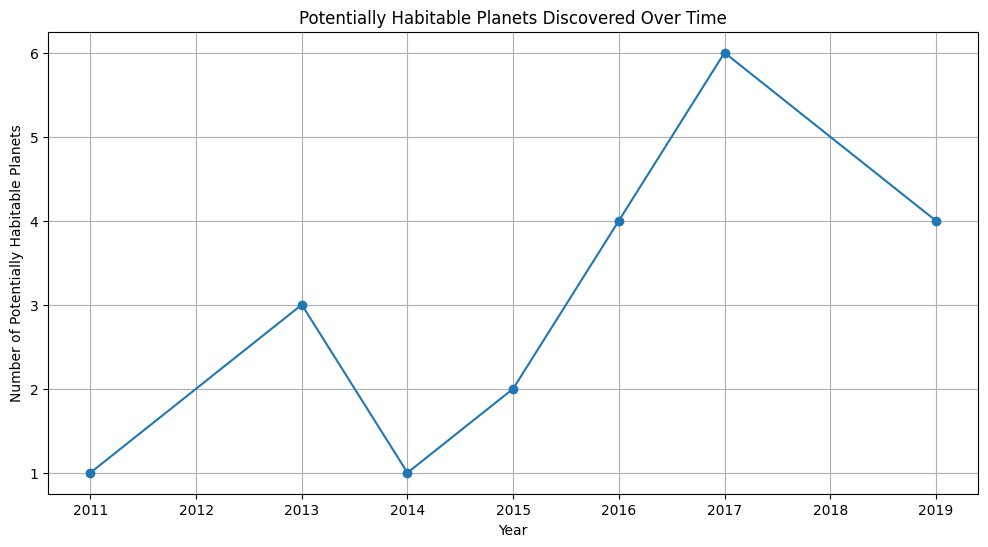

In [ ]:
plt.figure(figsize=(12, 6))
yearly_habitable_planets.plot(kind='line', marker='o')
plt.title('Potentially Habitable Planets Discovered Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Potentially Habitable Planets')
plt.grid(True)
plt.show()


## Moving on to the Bar Chart


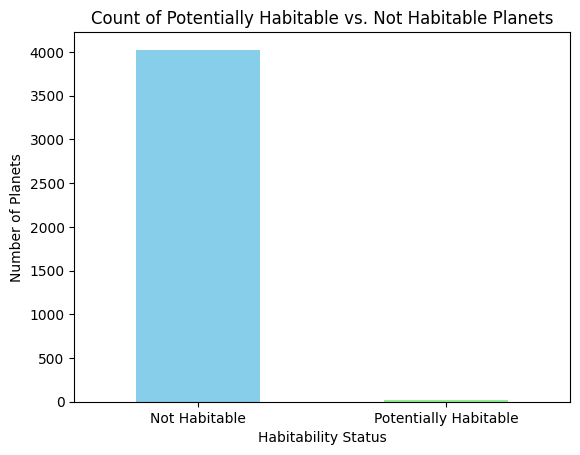

In [ ]:
habitable_status_counts = df_cols_dropped['Is_Potentially_Habitable'].value_counts()
habitable_status_counts.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Count of Potentially Habitable vs. Not Habitable Planets')
plt.xlabel('Habitability Status')
plt.ylabel('Number of Planets')
plt.xticks(rotation=0)
plt.show()

## Histogram of Planet Masses





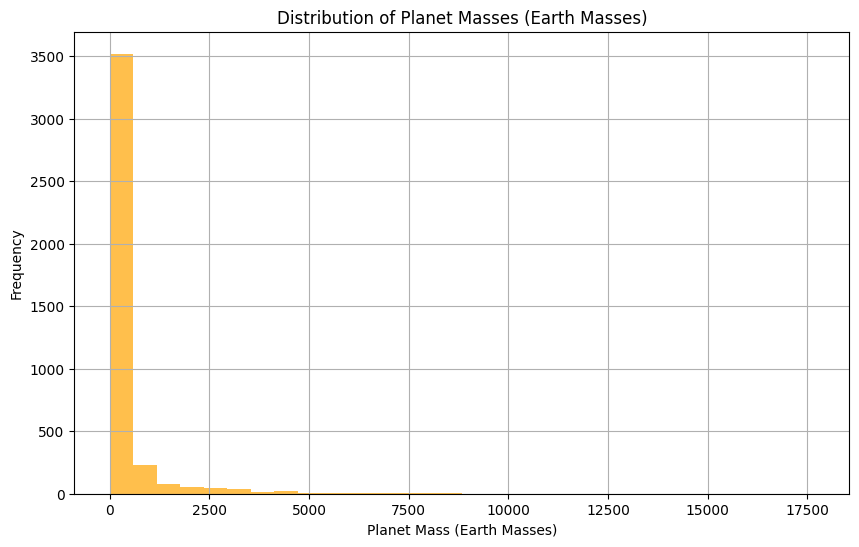

In [ ]:
plt.figure(figsize=(10, 6))
df_cols_dropped['P_MASS_EST'].hist(bins=30, color='orange', alpha=0.7)
plt.title('Distribution of Planet Masses (Earth Masses)')
plt.xlabel('Planet Mass (Earth Masses)')
plt.ylabel('Frequency')
plt.show()


## Scatter Plot of Mass vs. Radius


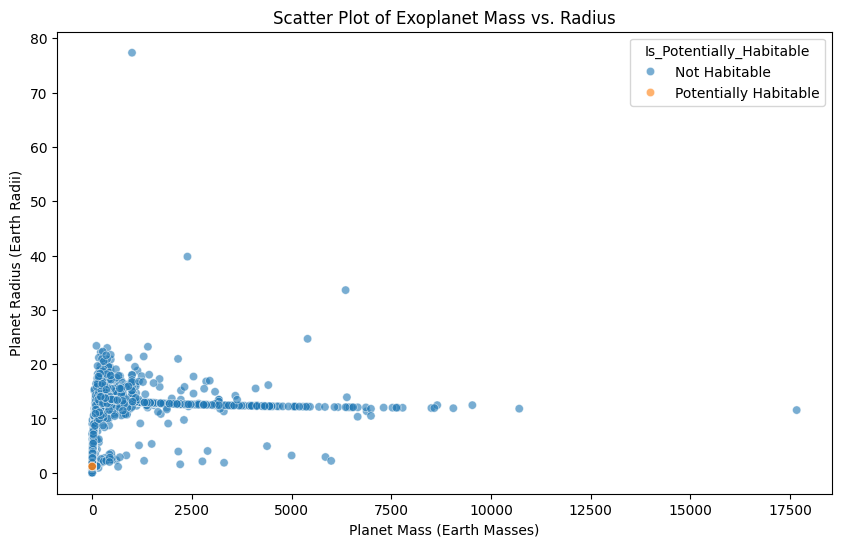

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='P_MASS_EST', y='P_RADIUS_EST', hue='Is_Potentially_Habitable', data=df_cols_dropped, alpha=0.6)
plt.title('Scatter Plot of Exoplanet Mass vs. Radius')
plt.xlabel('Planet Mass (Earth Masses)')
plt.ylabel('Planet Radius (Earth Radii)')
plt.show()

## Pie Chart of Habitable Status


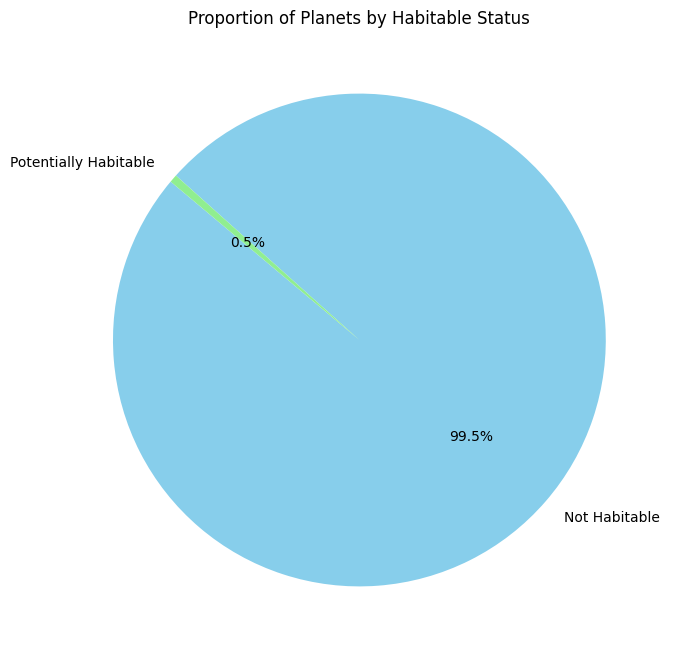

In [ ]:
plt.figure(figsize=(8, 8))
df_cols_dropped['Is_Potentially_Habitable'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen'])
plt.title('Proportion of Planets by Habitable Status')
plt.ylabel('')  # Hide the y-label
plt.show()

## Box Plot of Stellar Flux by Habitable Status


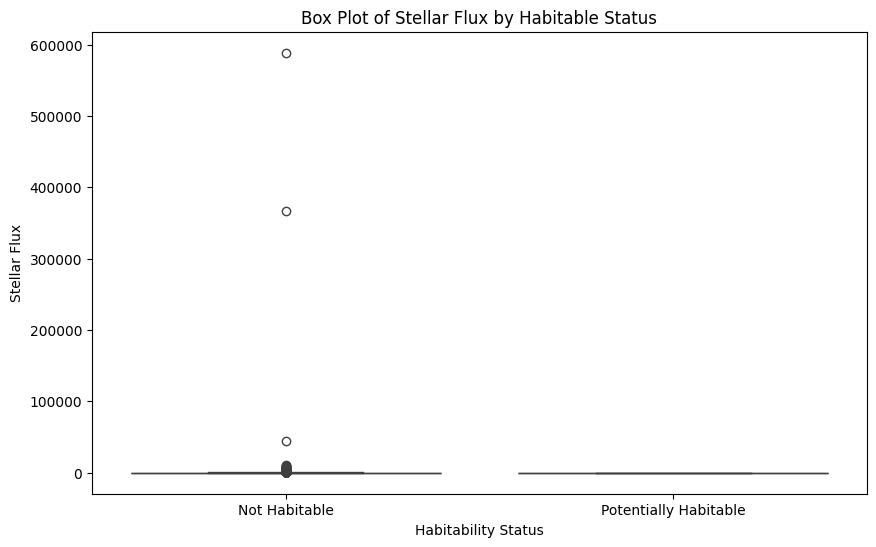

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Is_Potentially_Habitable', y='P_FLUX', data=df_cols_dropped)
plt.title('Box Plot of Stellar Flux by Habitable Status')
plt.xlabel('Habitability Status')
plt.ylabel('Stellar Flux')
plt.show()

## Correlation Analysis


In [ ]:
numeric_df = df.select_dtypes(include=[np.number])
correlation_mat = numeric_df.corr().abs()
print(correlation_mat)

                       P_STATUS    P_MASS  P_MASS_ERROR_MIN  P_MASS_ERROR_MAX  \
P_STATUS                    NaN       NaN               NaN               NaN   
P_MASS                      NaN  1.000000          0.586394          0.512819   
P_MASS_ERROR_MIN            NaN  0.586394          1.000000          0.847396   
P_MASS_ERROR_MAX            NaN  0.512819          0.847396          1.000000   
P_RADIUS                    NaN  0.243671          0.218779          0.090935   
...                         ...       ...               ...               ...   
P_HABITABLE                 NaN  0.064295          0.022998          0.020819   
P_ESI                       NaN  0.141129          0.080344          0.072911   
P_RADIUS_EST                NaN  0.260319          0.115873          0.092648   
P_MASS_EST                  NaN  1.000000          0.586394          0.512819   
P_SEMI_MAJOR_AXIS_EST       NaN  0.212207          0.099808          0.069684   

                       P_RA

## Plot the correlation matrix using heatmap



<Axes: >

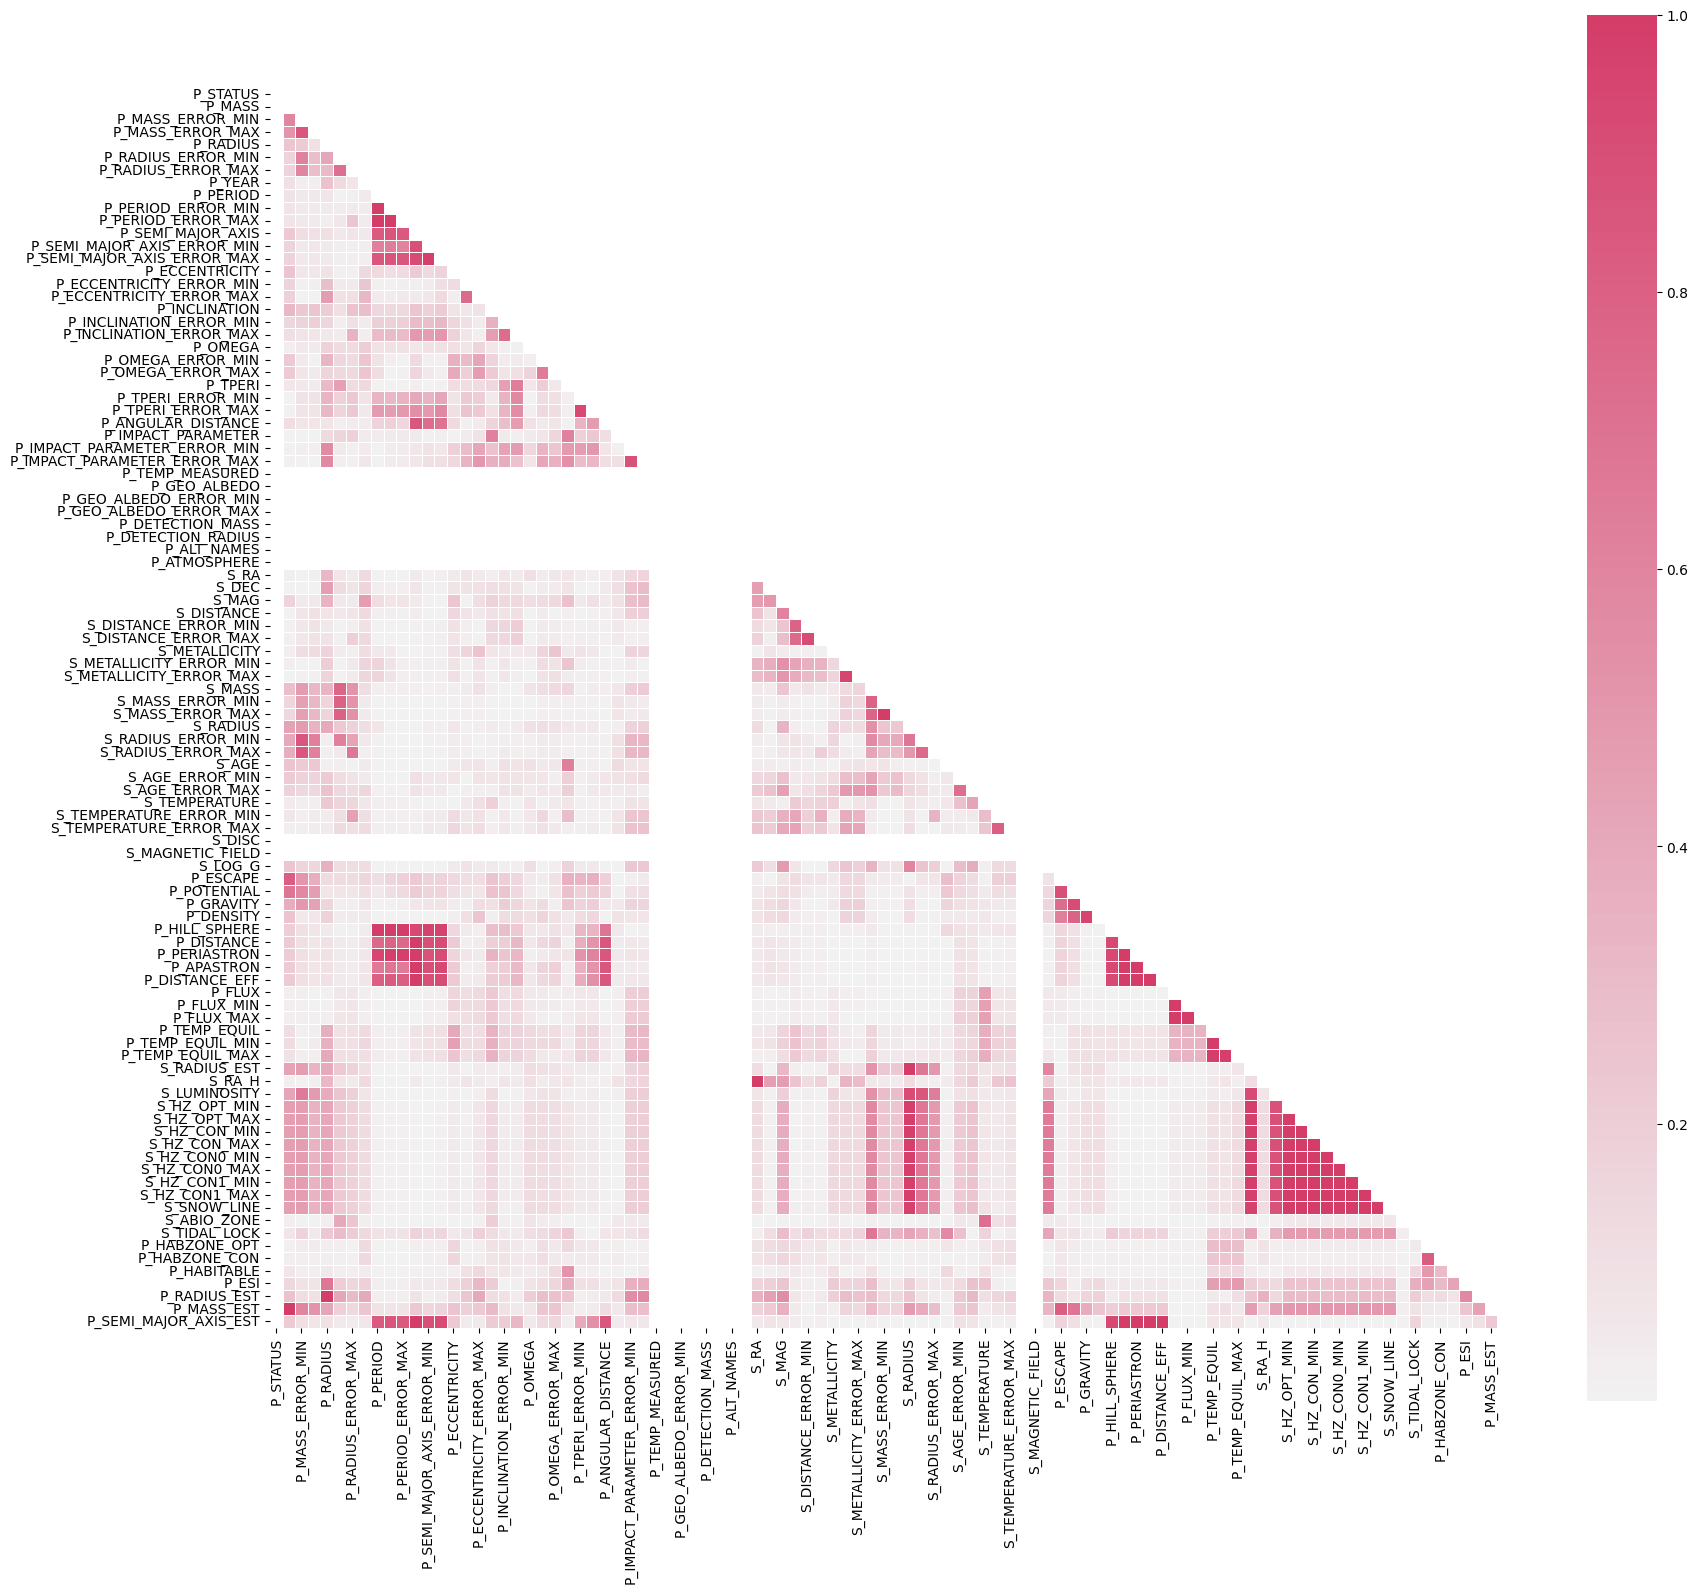

In [ ]:
import matplotlib.pyplot as plt
mask = np.triu(np.ones_like(correlation_mat, dtype = np.bool_))
f, ax = plt.subplots(figsize = (20, 20))
cmap = sns.diverging_palette(255, 0, as_cmap = True)
sns.heatmap(correlation_mat, mask = mask, cmap = cmap,\
vmax = None,center = 0, square = True, annot = False, \
linewidths = .5, cbar_kws = {"shrink": 0.9})

## Planetary Detection Method:

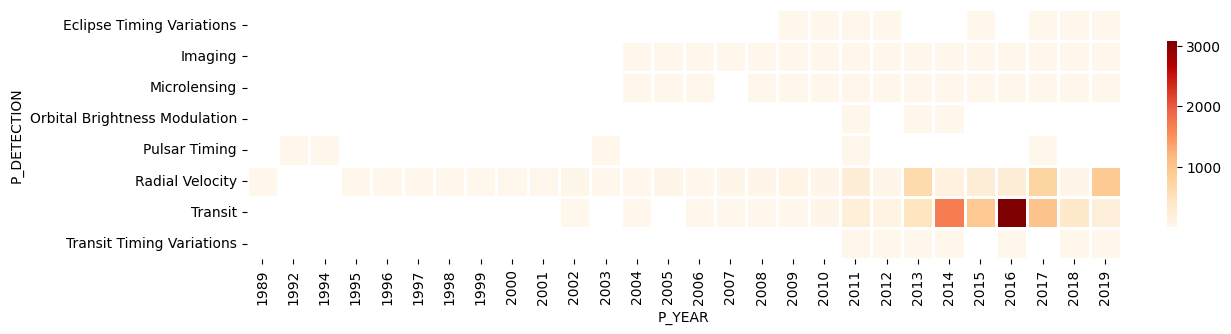

In [ ]:
by_p_detec = (oversampled
            .groupby('P_DETECTION')
            .filter(lambda x : len(x) > 5)
            .groupby(['P_DETECTION', 'P_YEAR'])
            .size()
            .unstack()
           )
import seaborn as sns
plt.figure(figsize=(12,12))
g = sns.heatmap(
    by_p_detec,
    square=True,
    cbar_kws={'fraction' : 0.01},
    cmap='OrRd',
    linewidth=1
)

## Generating a catplot

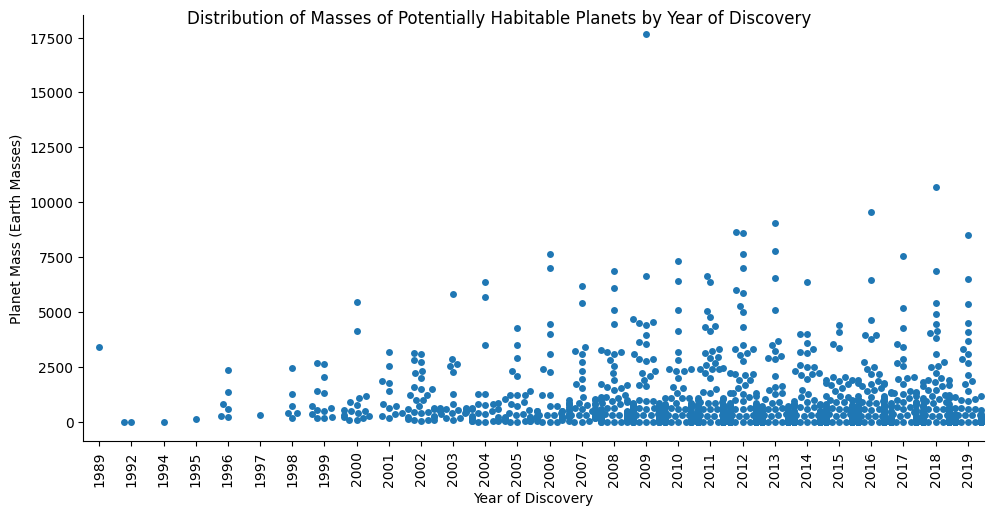

In [ ]:
catplot = sns.catplot(
    x='P_YEAR',
    y='P_MASS_EST',
    kind="swarm",
    data=df_cols_dropped,
    height=5,
    aspect=2
)

catplot.set_xticklabels(rotation=90)
catplot.set_axis_labels("Year of Discovery", "Planet Mass (Earth Masses)")
catplot.fig.suptitle('Distribution of Masses of Potentially Habitable Planets by Year of Discovery')

plt.show()


***Random Forest

```
# This is formatted as code
```

***

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Splitting the data into features and target

In [ ]:
# Assuming 'df' is your DataFrame after all preprocessing done above

X = df.drop('P_HABITABLE', axis=1)  # Feature matrix
y = df['P_HABITABLE']  # Target vector

# Encoding categorical data (if any)
X = pd.get_dummies(X)

# Standardize the features (important for many ML algorithms)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 0)


In [ ]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Apply imputer to the scaled training and testing sets
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Initializing the Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=0)

# Training the model using imputed data
classifier.fit(X_train_imputed, y_train)

# Predicting the Test set results using imputed data
y_pred = classifier.predict(X_test_imputed)

# Making the Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# Printing the classification report
print(classification_report(y_test, y_pred))

# Printing the accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))


[[796   1   0]
 [  2   4   0]
 [  7   0   0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       797
           1       0.80      0.67      0.73         6
           2       0.00      0.00      0.00         7

    accuracy                           0.99       810
   macro avg       0.60      0.56      0.57       810
weighted avg       0.98      0.99      0.98       810

Accuracy: 0.9876543209876543


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initializing the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=0)

# Training the model using the imputed and scaled training data
log_reg.fit(X_train_imputed, y_train)

# Predicting the test set results
y_pred_log_reg = log_reg.predict(X_test_imputed)

# Evaluating the model
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
classification_rep_log_reg = classification_report(y_test, y_pred_log_reg)

print("Logistic Regression Accuracy:", accuracy_log_reg)
print("Logistic Regression Classification Report:\n", classification_rep_log_reg)


Logistic Regression Accuracy: 0.9851851851851852
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       797
           1       1.00      0.17      0.29         6
           2       0.00      0.00      0.00         7

    accuracy                           0.99       810
   macro avg       0.66      0.39      0.43       810
weighted avg       0.98      0.99      0.98       810



# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initializing the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=0)

# Training the model using the imputed and scaled training data
dt_classifier.fit(X_train_imputed, y_train)

# Predicting the test set results
y_pred_dt = dt_classifier.predict(X_test_imputed)

# Evaluating the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
classification_rep_dt = classification_report(y_test, y_pred_dt)

print("Decision Tree Accuracy:", accuracy_dt)
print("Decision Tree Classification Report:\n", classification_rep_dt)


Decision Tree Accuracy: 0.9962962962962963
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       797
           1       1.00      0.83      0.91         6
           2       0.78      1.00      0.88         7

    accuracy                           1.00       810
   macro avg       0.93      0.94      0.93       810
weighted avg       1.00      1.00      1.00       810



# Comparing all three models

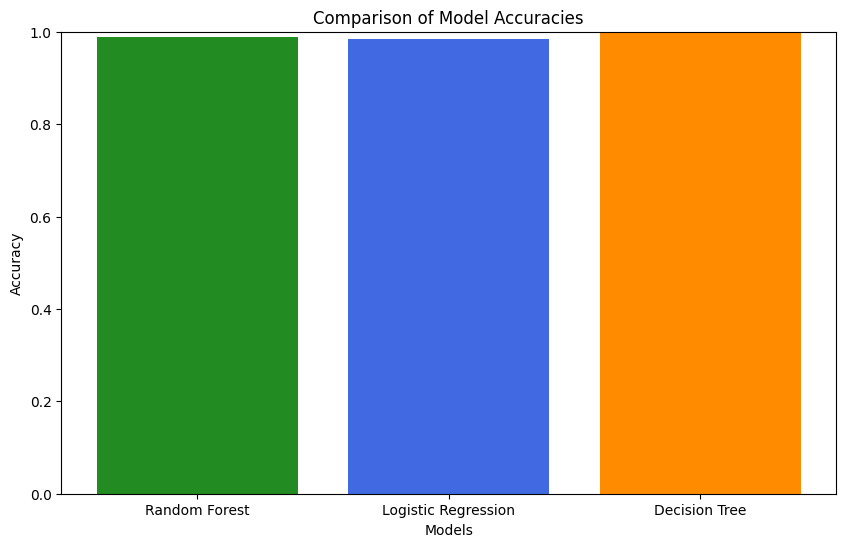

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already calculated the accuracies for each model
# For example:
accuracy_rf = accuracy_score(y_test, y_pred)  # Random Forest
accuracy_lr = accuracy_score(y_test, y_pred_log_reg)  # Logistic Regression
accuracy_dt = accuracy_score(y_test, y_pred_dt)  # Decision Tree

# Names of models
models = ['Random Forest', 'Logistic Regression', 'Decision Tree']

# Corresponding accuracies
accuracies = [accuracy_rf, accuracy_lr, accuracy_dt]

# Creating the bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['forestgreen', 'royalblue', 'darkorange'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim([0, 1])  # Adjust y-axis limits to fit your accuracy scale if necessary
plt.show()


In [ ]:
pip install graphviz
